<a href="https://colab.research.google.com/github/sanghyun-ai/ktcloud_genai/blob/main/%EC%8B%A4%EC%8A%B5%EC%BD%94%EB%93%9C/206_LLM_%EB%B6%84%EB%A5%98%EC%9A%A9_%ED%91%9C%ED%98%84%EB%AA%A8%EB%8D%B8_%ED%8C%8C%EC%9D%B8%ED%8A%9C%EB%8B%9D%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **분류용 표현 모델 미세 튜닝하기**



---


- 💡 **NOTE**
    - 이 노트북의 코드를 실행하려면 GPU를 사용하는 것이 좋습니다. 구글 코랩에서는 **런타임 > 런타임 유형 변경 > 하드웨어 가속기 > T4 GPU**를 선택하세요.


---



In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
%%capture
!pip install datasets setfit seqeval

- **datasets** :
    - https://huggingface.co/datasets
    - 허깅페이스 데이터셋
- **setfit** :
    - https://huggingface.co/docs/setfit/index
    - 적은 양의 레이블 데이터만으로 문장 변환(Sentence Transformer) 모델을 효율적으로 파인튜닝하기 위한 프레임워크
- **seqeval** :
    - https://huggingface.co/spaces/evaluate-metric/seqeval
    - 개체명 인식(NER:Named Entity Recognition)과 같은 시퀀스 레이블링(sequence labeling) 태스크의 성능(F1-score, 정밀도 등)을 평가하기 위한 라이브러리

## **데이터**

In [3]:
from datasets import load_dataset

# 데이터를 준비하고 분할합니다.
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [4]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})



---



## **지도 분류**


- **앞에서 사용했던 텍스트 분류 방법**
<img src="https://drive.google.com/uc?export=view&id=1vhjfJWYAwuuy58sg0HJa-0AoGLQQe_EY" width="80%">


여기서 미세튜닝할 분류헤드란? 분류기 = 위에서 로지스틱 회귀같은 분류기만 훈련시키는거..

- **텍스트 분류 미세튜닝 아키텍처**
<img src="https://drive.google.com/uc?export=view&id=1NITz-bQO_hs_GWfW2OEKq_pkbGOjS9PZ" width="80%">


- **텍스트 분류 미세튜닝 방법**
<img src="https://drive.google.com/uc?export=view&id=1MuQgvpBGvD1DtL4EgN-ejhTOX5ZBwwsc" width="80%">




---




### **사전 훈련된 모델(BERT) 지정**

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 모델과 토크나이저를 로드합니다.
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
            model_id, num_labels=2)  # 레이블 개수 2개
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

데이터를 토큰으로 나눕니다.

In [6]:
def preprocess_function(examples):
   """입력 데이터를 토큰으로 나눕니다"""
   return tokenizer(examples["text"], truncation=True)

# 훈련 데이터와 테스트 데이터를 토큰화합니다.
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

DataCollator: 배치 데이터를 만들고 데이터 증식도 적용할 수 있는 클래스

In [7]:
from transformers import DataCollatorWithPadding

# 배치에서 가장 긴 시퀀스에 맞춰 패딩합니다.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

측정 지표를 정의합니다.
- **F1-score**
    - 데이터 불균형(Imbalanced Data)이 심할 때 모델의 성능을 정확하게 평가하기 위해 주로 사용
    - 정밀도(Precision)와 재현율(Recall)을 모두 중요하게 고려해야 할 때 사용

In [8]:
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    """F1 점수를 계산합니다"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

모델을 훈련합니다.

In [9]:
from transformers import TrainingArguments, Trainer

# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,              # 0.00002
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch", # 반복할때마다 에폭 저장
   report_to="none"
)

# 훈련 과정을 수행할 Trainer 객체
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [10]:
trainer.train()

Step,Training Loss
500,0.402400


TrainOutput(global_step=534, training_loss=0.39938271983285967, metrics={'train_runtime': 100.1831, 'train_samples_per_second': 85.144, 'train_steps_per_second': 5.33, 'total_flos': 227605451772240.0, 'train_loss': 0.39938271983285967, 'epoch': 1.0})

모델을 평가합니다.

In [11]:
trainer.evaluate()

{'eval_loss': 0.36681538820266724,
 'eval_f1': 0.8502325581395349,
 'eval_runtime': 4.166,
 'eval_samples_per_second': 255.881,
 'eval_steps_per_second': 16.083,
 'epoch': 1.0}

### **층 동결**

피드포워드 신경망만 훈련하기

- **신경망 층 동결**
<img src="https://drive.google.com/uc?export=view&id=1ZDg0vb99sMthQK-BWxXud40ynJe7IPtN" width="80%">


In [12]:
# 모델과 토크나이저를 로드합니다.
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# 층 이름을 출력합니다.
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

classifier 를 제외한 모든 층 동결하기

In [14]:
for name, param in model.named_parameters():

     # 분류 헤드는 동결하지 않습니다.
     if name.startswith("classifier"):
        param.requires_grad = True      # 이 파라미터는 훈련 중에 업데이트되어야 한다는 의미

     # 그외 모든 층을 동결합니다.
     else:
        param.requires_grad = False


(기본적으로 인코더 기반 모델들은 레이어를 12개 가지고 있음)

맨 마지막

199: classifier.weight ----- True

200: classifier.bias ----- True

나머지는 False인데 이 두개 레이어만 True로 학습됨

In [17]:
# 모델이 올바르게 업데이트되었는지 확인합니다.
for index, (name, param) in enumerate(model.named_parameters()):
     print(f"{index}: {name} ----- {param.requires_grad}")

# 동결 안한 층(분류 헤드)
#  - classifier.weight
#  - classifier.bias

0: bert.embeddings.word_embeddings.weight ----- False
1: bert.embeddings.position_embeddings.weight ----- False
2: bert.embeddings.token_type_embeddings.weight ----- False
3: bert.embeddings.LayerNorm.weight ----- False
4: bert.embeddings.LayerNorm.bias ----- False
5: bert.encoder.layer.0.attention.self.query.weight ----- False
6: bert.encoder.layer.0.attention.self.query.bias ----- False
7: bert.encoder.layer.0.attention.self.key.weight ----- False
8: bert.encoder.layer.0.attention.self.key.bias ----- False
9: bert.encoder.layer.0.attention.self.value.weight ----- False
10: bert.encoder.layer.0.attention.self.value.bias ----- False
11: bert.encoder.layer.0.attention.output.dense.weight ----- False
12: bert.encoder.layer.0.attention.output.dense.bias ----- False
13: bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
14: bert.encoder.layer.0.attention.output.LayerNorm.bias ----- False
15: bert.encoder.layer.0.intermediate.dense.weight ----- False
16: bert.encoder.layer.0

In [16]:
from transformers import TrainingArguments, Trainer

# 훈련 과정을 실행할 Trainer 객체를 만듭니다.
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.694700


TrainOutput(global_step=534, training_loss=0.6948552792438407, metrics={'train_runtime': 37.5935, 'train_samples_per_second': 226.901, 'train_steps_per_second': 14.205, 'total_flos': 227605451772240.0, 'train_loss': 0.6948552792438407, 'epoch': 1.0})

In [18]:
trainer.evaluate()

{'eval_loss': 0.6825135946273804,
 'eval_f1': 0.64,
 'eval_runtime': 4.0436,
 'eval_samples_per_second': 263.629,
 'eval_steps_per_second': 16.57,
 'epoch': 1.0}

### **10개의 인코더 블록 동결하기**

- **층 일부 블록 동결**
<img src="https://drive.google.com/uc?export=view&id=1BLWermWu06u6e5vqzOF7XmmdexGAut-f" width="80%">


In [19]:
# 모델을 로드합니다.
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 11번째 인코더 블록은 인덱스 165에서 시작합니다.
# 이 블록 이전의 모든 층을 동결합니다.
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# 훈련 과정을 실행할 Trainer 객체를 만듭니다.
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.476100


{'eval_loss': 0.4100649952888489,
 'eval_f1': 0.8072519083969466,
 'eval_runtime': 3.7157,
 'eval_samples_per_second': 286.888,
 'eval_steps_per_second': 18.031,
 'epoch': 1.0}

### **인코더 블록 동결의 효과**
인코더 블록을 점차 훈련하면 모든 인코더 블록을 훈련했을 때의 성능과 거의 비슷한 수준에 도달합니다.

In [20]:
# 시간이 오래 걸립니다!
scores = []
for index in range(12):
    # 모델을 다시 로드합니다.
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

    # 인코더 블록 0-index를 동결합니다.
    for name, param in model.named_parameters():
        if "layer" in name:
            layer_nr = int(name.split("layer")[1].split(".")[1])
            if layer_nr <= index:
                param.requires_grad = False
        else:
            param.requires_grad = True

    # 모델 훈련
    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset=tokenized_test,
      processing_class=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
    )
    trainer.train()

    # 평가
    score = trainer.evaluate()["eval_f1"]
    scores.append(score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.405600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.406100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.406600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.408100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.411300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.415100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.421800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.430100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.446200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.472200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.518100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.655600


In [21]:
scores

[0.8493919550982226,
 0.8541862652869238,
 0.8528584817244611,
 0.8466603951081844,
 0.8388312912346843,
 0.839134524929445,
 0.8434864104967198,
 0.8358490566037736,
 0.8258801141769743,
 0.8164435946462715,
 0.7925270403146509,
 0.7058823529411765]

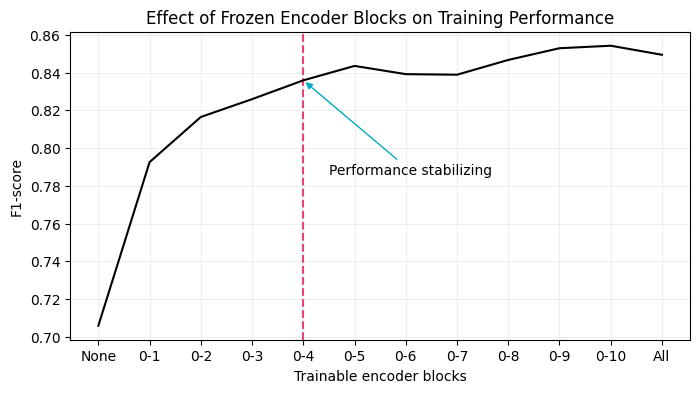

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 피겨 객체를 만듭니다.
plt.figure(figsize=(8,4))

# 데이터를 준비합니다.
x = [f"0-{index}" for index in range(12)]
x[0] = "None"
x[-1] = "All"
y = scores[::-1]

# 그래프 스타일 설정
plt.grid(color='#ECEFF1')
plt.axvline(x=4, color="#EC407A", linestyle="--")
plt.title("Effect of Frozen Encoder Blocks on Training Performance")
plt.ylabel("F1-score")
plt.xlabel("Trainable encoder blocks")

# 그래프를 그립니다.
plt.plot(x, y, color="black")

# 그래프 주석 추가
plt.annotate(
    'Performance stabilizing',
    xy=(4, y[4]),
    xytext=(4.5, y[4]-.05),
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3",
        color="#00ACC1")
)
plt.savefig("multiple_frozen_blocks.png", dpi=300, bbox_inches='tight')

위 그림상 위치 말고 실제 데이터상으로는 0-5 구간 정도가 변곡점이 됨!



---



## **퓨-샷 분류**

- **Few-Shot 분류** (Few-Shot Classification)
    - 적은 수의 예제(few examples)만으로도 새로운 클래스를 분류할 수 있게 학습하는 방법
        - 일반 학습: 클래스당 수천~수만 개
        - Few-Shot 학습 : 클래스당 1~10개
    - 사람이 동물 사진 1장만 보고 새로운 동물을 인식하는 것처럼,AI도 적은 예제로 새로운 것을 학습할 수 있게 만드는 기술
    - 목표 = 빠른 적응력 (Quick Adaptation)
    - 방법 = 메타 러닝 + 유사도 학습


### **Setfit**
- https://huggingface.co/docs/setfit/index
- 적은 양의 레이블 데이터만으로 문장 변환(**Sentence Transformer**) 모델을 효율적으로 파인튜닝하기 위한 프레임워크

- **SetFit 알고리즘 세 단계**
    1. **훈련 데이터 샘플링**
        - 레이블이 있는 데이터를 같은 클래스끼리 묶거나 다른 클래스끼리 묶어서 (비슷한) 양성 문장 쌍과 (비슷하지 않은) 음성 문장 쌍을 생성
    2. **임베딩 미세 튜닝**
        - 앞서 생성한 훈련 데이터를 기반으로 사전 훈련된 임베딩 모델을 미세 튜닝함
    3. **분류기 훈련**
        - 임베딩 모델 위에 분류 헤드를 놓고 앞서 생성한 훈련 데이터를 사용해 훈련함

<img src="https://drive.google.com/uc?export=view&id=1Ikfs8XWmtF8pMnCD8T5sUp4EoIj5jHgZ" width="80%">


### **SetFilt: 소량의 샘플로 효율적인 미세 튜닝하기**

In [23]:
from setfit import sample_dataset

# 퓨-샷 설정을 흉내내기 위해 클래스마다 16개의 샘플을 선택합니다.
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


- sentence-transformers/all-mpnet-base-v2 :
    - 문장이나 단락을 의미적으로 유사한 내용끼리 가깝게 배치되는 768차원의 숫자 벡터(임베딩)로 변환해주는, 성능이 뛰어난 범용 모델 중 하나

In [24]:
from setfit import SetFitModel

# 사전 훈련된 SentenceTransformer 모델을 로드합니다.
# 분류 헤드(분류기)를 직접 지정하지 않으면, default LogisticRegression 사용함
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [25]:
# model head 확인하기
model.model_head

# 모델이 학습되지 않아서 주황색으로 나타남
# 학습한 상태는 하늘색

LogisticRegression()

In [30]:
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

# 훈련 매개변수를 정의합니다.
args = SetFitTrainingArguments(
    num_epochs=3,      # 대조 학습을 수행할 에포크 횟수
    num_iterations=20  # 생성할 텍스트 쌍 개수
)
args.eval_strategy = args.evaluation_strategy

# Trainer 객체를 만듭니다.
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [31]:
# 훈련 루프
trainer.train()

# wandb(Weights & Biases):
# 머신러닝 모델의 훈련 과정(손실, 정확도 등)과 결과물을 자동으로 기록하고 시각화하여
# 실험을 체계적으로 관리하고 다른 실험과 비교할 수 있게 도와주는 MLOps(기계 학습 운영) 도구

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aivhyun (aivhyun-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:263: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


Step,Training Loss,Validation Loss


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:

In [32]:
# 테스트 데이터에서 모델을 평가합니다.
trainer.evaluate()

***** Running evaluation *****
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


{'f1': 0.8454011741682974}

In [33]:
model.model_head

LogisticRegression()



---



## **마스크드 언어 모델링**

- **도메인 특화 튜닝 방법**
<img src="https://drive.google.com/uc?export=view&id=17-fvjB5K9iptHyx5VoMinLWRvk-Au78B" width="80%">


- **실제 튜닝 사례**
<img src="https://drive.google.com/uc?export=view&id=18dgu-OG8g-5QtNYQ_CI1LM4E1xByiP6F" width="80%">

### **사전 훈련된 (BERT)모델 계속 훈련하는 방법**

In [34]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# 마스크드 언어 모델링을 위해 모델을 로드합니다.
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- 사용 데이터셋: 로튼 영화 리뷰 데이터
    - 아마도, Mask 처리된 곳에는 영화 관련 단어(토큰)들에 특화될 것이다.

In [35]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# 데이터를 토큰화합니다.
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

- 마스킹 방법
    - 토큰 마스킹 : 단어 바스킹보다는 비교적 빠른 수렴
    - 전체 단어 마스킹 : 정료하지만 복잡하고 느리다
- 토큰 마스킹 --> 빠르게 하기 위해!
    - 문장에 있는 토큰의 15%를 랜덤하게 마스킹함
    - 단어의 일부분만 마스킹 될 수 있다.

In [36]:
from transformers import DataCollatorForLanguageModeling

# 토큰 마스킹
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [37]:
# from transformers import DataCollatorForWholeWordMask

# # 전체 단어 마스킹
# data_collator = DataCollatorForWholeWordMask(
#     tokenizer=tokenizer,
#     mlm=True,
#     mlm_probability=0.15
# )

In [38]:
# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


In [39]:
# 훈련 시간이 오래 걸림(T4 20분 이상)
# 사전 훈련된 토크나이저를 저장합니다.
tokenizer.save_pretrained("mlm")

# 모델을 훈련합니다.
trainer.train()

# 업데이트된 모델을 저장합니다.
model.save_pretrained("mlm")

Step,Training Loss
500,2.604500
1000,2.371400
1500,2.306700
2000,2.191000
2500,2.150500
3000,2.089400
3500,2.053600
4000,1.993700
4500,1.987100
5000,1.955500


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/py

- **Mask 예측 결과 확인: (원본 모델)**

In [40]:
from transformers import pipeline

# 모델을 로드하고 예측을 만듭니다.
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# 결과를 출력합니다.
for pred in preds:
    print(f">>> {pred['sequence']}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


- **Mask 예측 결과 확인: (업데이트된 모델)**

In [41]:
# 모델을 로드하고 예측을 만듭니다.
# 마스크 예측 결과 개수 지정 방법
mask_filler = pipeline("fill-mask", model="mlm", top_k=10)
preds = mask_filler("What a horrible [MASK]!")

# mask_filler = pipeline("fill-mask", model="mlm")
# preds = mask_filler("What a horrible [MASK]!", top_k=10)

# 결과를 출력합니다.
for pred in preds:
    print(f">>> {pred['sequence']}")

Device set to use cuda:0


>>> What a horrible movie!
>>> What a horrible film!
>>> What a horrible mess!
>>> What a horrible comedy!
>>> What a horrible story!
>>> What a horrible picture!
>>> What a horrible drama!
>>> What a horrible thing!
>>> What a horrible documentary!
>>> What a horrible idea!


In [42]:
preds[:5]

[{'score': 0.5714176893234253,
  'token': 2523,
  'token_str': 'movie',
  'sequence': 'What a horrible movie!'},
 {'score': 0.15109024941921234,
  'token': 1273,
  'token_str': 'film',
  'sequence': 'What a horrible film!'},
 {'score': 0.06939338892698288,
  'token': 6477,
  'token_str': 'mess',
  'sequence': 'What a horrible mess!'},
 {'score': 0.015928637236356735,
  'token': 3789,
  'token_str': 'comedy',
  'sequence': 'What a horrible comedy!'},
 {'score': 0.01195975299924612,
  'token': 1642,
  'token_str': 'story',
  'sequence': 'What a horrible story!'}]

In [43]:
len(preds)

10



---



## **개체명 인식**

- **개체명 인식** (**NER** named-entity recognition)
- 전체 문서를 분류하는 것이 아니라 **사람이나 위치 등이 포함된 개별 토큰이나 단어를 분류**함
- 민감한 데이터가 있을 때 익명화하는 작업에 특별히 도움됨
- 개별 단어를 분류하는 데 초점을 맞추려면 세분화된 구조를 고려하도록 데이터를 전처리해야 한다.
- 분류 방식:
    - **모델이 시퀀스에 있는 개별 토큰에 대해 예측**을 만든다



In [44]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import numpy as np

In [45]:
# CoNLL-2003 데이터셋
# dataset = load_dataset("conll2003", trust_remote_code=True) # 오류

dataset = load_dataset("conll2003", revision="refs/convert/parquet")

conll2003/train/0000.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/283k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [46]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [47]:
example = dataset["train"][848]
example

{'id': '848',
 'tokens': ['Dean',
  'Palmer',
  'hit',
  'his',
  '30th',
  'homer',
  'for',
  'the',
  'Rangers',
  '.'],
 'pos_tags': [22, 22, 38, 29, 16, 21, 15, 12, 23, 7],
 'chunk_tags': [11, 12, 21, 11, 12, 12, 13, 11, 12, 0],
 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}

- **ner_tags** : 개체명 태그
    - 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}
    - 사람(PER),조직(ORG), 위치(LOC), 기타매체(MISC), 개체아님(O)
    - 개체마다 B(시작),I(중간)

- **동일한 개체 구분해서 표현**
<img src="https://drive.google.com/uc?export=view&id=1tHeHCJ0hw16WEqGPkc3cBP2S23OLC6o3" width="80%">

In [48]:
label2id = {
    'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [49]:
from transformers import AutoModelForTokenClassification

# 토크나이저를 로드합니다.
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# 모델을 로드합니다.
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


토크나이저가 샘플을 처리하는 방법 확인

In [50]:
example["tokens"]

['Dean', 'Palmer', 'hit', 'his', '30th', 'homer', 'for', 'the', 'Rangers', '.']

In [51]:
# 개별 토큰을 부분 토큰으로 나눕니다.
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

# is_split_into_words=True: 토크나이저가 단어 리스트로 처리하도록 지시 (NER 라벨 정렬에 유리)
# ["input_ids"]: 토큰화된 결과 중 정수 ID 시퀀스만 꺼냄

['[CLS]',
 'Dean',
 'Palmer',
 'hit',
 'his',
 '30th',
 'home',
 '##r',
 'for',
 'the',
 'Rangers',
 '.',
 '[SEP]']

- align_labels
    - 입력을 토큰으로 나누고, 토큰을 업데이트된 레이블로 정렬하는 함수

In [52]:
def align_labels(examples):
    token_ids = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = examples["ner_tags"]

    updated_labels = []
    for index, label in enumerate(labels):

        # 토큰을 해당 단어에 매핑합니다.
        word_ids = token_ids.word_ids(batch_index=index)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:

            # 새로운 단어의 시작
            if word_idx != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # 특수 토큰은 -100
            elif word_idx is None:
                label_ids.append(-100)

            # # 레이블이 B-XXX이면 I-XXX로 바꿉니다.
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(updated_label)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids

tokenized = dataset.map(align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [53]:
# 원본 레이블와 업데이트된 레이블
print(f"원본 레이블: {example['ner_tags']}")
print(f"업데이트된 레이블: {tokenized['train'][848]['labels']}")

# [CLS], [SEP] -100 으로 추가됨

원본 레이블: [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]
업데이트된 레이블: [-100, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, -100]


In [54]:
import evaluate

# seqeval을 로드합니다.
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # 예측을 만듭니다.
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # 문서 수준 반복
    for prediction, label in zip(predictions, labels):

      # 토큰 수준 반복
      for token_prediction, token_label in zip(prediction, label):

        # 특수 토큰은 무시합니다.
        if token_label != -100:
          true_predictions.append([id2label[token_prediction]])
          true_labels.append([id2label[token_label]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

In [55]:
from transformers import DataCollatorForTokenClassification

# 토큰 분류 DataCollator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [56]:
# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.229600


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/py

TrainOutput(global_step=878, training_loss=0.16654812067679228, metrics={'train_runtime': 194.4627, 'train_samples_per_second': 72.204, 'train_steps_per_second': 4.515, 'total_flos': 351240792638148.0, 'train_loss': 0.16654812067679228, 'epoch': 1.0})

In [57]:
# 테스트 데이터에서 모델을 평가합니다.
trainer.evaluate()

{'eval_loss': 0.1407972127199173,
 'eval_f1': 0.9041690608440274,
 'eval_runtime': 10.8377,
 'eval_samples_per_second': 318.609,
 'eval_steps_per_second': 19.93,
 'epoch': 1.0}

- **모델 저장 및 추론 수행**

In [58]:
from transformers import pipeline

# 미세 튜닝된 모델을 저장합니다.
trainer.save_model("ner_model")

# 미세 튜닝된 모델로 추론을 수행합니다.
token_classifier = pipeline(
    "token-classification",
    model="ner_model",
)
token_classifier("My name is Maarten.")

Device set to use cuda:0


[{'entity': 'B-PER',
  'score': np.float32(0.98112583),
  'index': 4,
  'word': 'Ma',
  'start': 11,
  'end': 13},
 {'entity': 'I-PER',
  'score': np.float32(0.87977314),
  'index': 5,
  'word': '##arte',
  'start': 13,
  'end': 17},
 {'entity': 'I-PER',
  'score': np.float32(0.94458437),
  'index': 6,
  'word': '##n',
  'start': 17,
  'end': 18}]